# Rescale images based on projector greyscale transfer function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config Completer.use_jedi = False  #magic to fix autocomplete issue

### Specify measurements of screen brightness att 10 grey scale levels ranging from black (0) to white (1)

In [19]:
filename = 'ShivamRig_mean_brightness_level_6' #'HannahRig'#
postfix = "Shivam"#'Hannah' #
measurement = np.array(np.loadtxt(open('./screenMeasurements/{}.csv'.format(filename),'rb'), delimiter=",",skiprows=1)).T
reversevals = False
if filename == 'HannahRig':
    reversevals = True

In [20]:
data = measurement.copy()
if reversevals: data[0,:] = 1-data[0,:]
if min(data[0,:]) > 0: data[0,:] = data[0,:] - min(data[0,:])
if max(data[0,:]) >= 10:  data[0,:] = data[0,:]/10
data[1,:] = (data[1,:]-min(data[1,:]))/ max(data[1,:])

In [42]:
a = 0.1
b = 0.1
x = .2
min((np.sqrt(x**a) * b,1))

0.09226808345905885

/Users/haberkernh/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


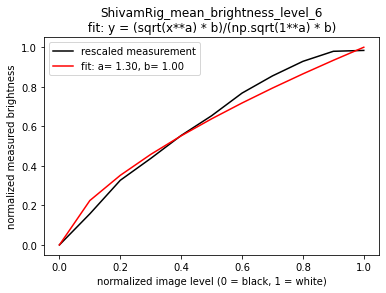

In [100]:
from scipy.optimize import curve_fit

xdata = data[0,:]
ydata = data[1,:]

if postfix == 'Hannah':
    def Fun(x, a, b):
        return  1/(1 + np.exp( (-x + b) * a) )
else:
    def Fun(x, a, b):
        return np.sqrt(x**a) * b / (np.sqrt(1**a) * b) 

popt, pcov = curve_fit(Fun, xdata, ydata)
fig, axs = plt.subplots(1,1, figsize=(6,4))
axs.plot(data[0,:],data[1,:], 'k', label='rescaled measurement')
axs.plot(xdata, Fun(xdata, *popt), 'r-',
         label='fit: a=%5.2f, b=%5.2f' % tuple(popt))

axs.set_xlabel('normalized image level (0 = black, 1 = white)')
axs.set_ylabel('normalized measured brightness')
axs.legend();
if postfix == 'Hannah':
    axs.set_title(filename + '\n fit: y = 1/(1 + np.exp( (-x + b) * a) )')
else:
    axs.set_title(filename + '\n fit: y = (sqrt(x**a) * b)/(np.sqrt(1**a) * b) ')
fig.savefig('./screenMeasurements/{}_fit.pdf'.format(filename))

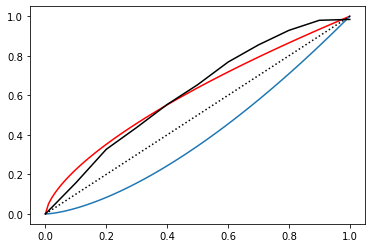

In [101]:
if postfix == 'Hannah':
    def InvFun(x, a, b):
        return   - ( np.log( (1-x)/x) /  a) + b
else:
    def InvFun(x, a, b):
        return np.power( (x * (np.sqrt(1**a) * b) ) / b , 2/a)

x = np.linspace(0,1, 100)
plt.plot(x, Fun(x, *popt), 'r-')
plt.plot(x, InvFun(x, *popt) )
plt.plot(data[0,:],data[1,:], 'k', label='rescaled measurement')
plt.plot(x, x, 'k:')

In [92]:
from PIL import Image

savename = '13h'
path = './skyGradients/'+savename+'/'
maxBit = 255

grad_F = np.asarray(Image.open(path + 'Skybox_mean_Front_{}.png'.format(savename)))

#rescale image
grad_F_rescaled = grad_F[:,:,0]/maxBit

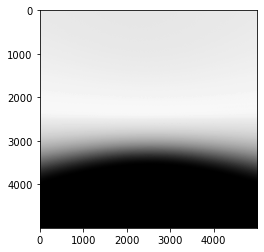

In [93]:
plt.imshow(grad_F_rescaled, cmap='gray',vmin=0,vmax=1)

In [94]:
grad_F_reshaped = grad_F_rescaled.copy()
grad_F_reshaped = InvFun(grad_F_rescaled, *popt) 
grad_F_reshaped[np.where(grad_F_reshaped == -np.inf)] = 0
grad_F_reshaped[np.where(grad_F_reshaped > 1)] = 1

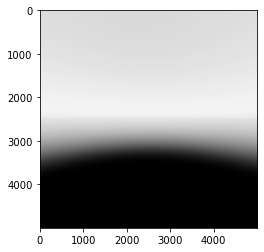

In [95]:
plt.imshow(grad_F_reshaped, cmap='gray',vmin=0,vmax=1)

(array([7862653.,  490813.,  413187.,  370589.,  402565.,  459071.,
         541084.,  692702., 4494759., 9272577.]),
 array([0.        , 0.09639604, 0.19279209, 0.28918813, 0.38558417,
        0.48198021, 0.57837626, 0.6747723 , 0.77116834, 0.86756438,
        0.96396043]),
 <BarContainer object of 10 artists>)

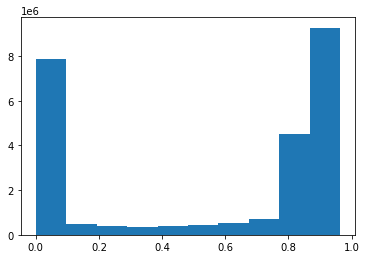

In [96]:
plt.hist(grad_F_reshaped.flatten())

(array([ 7317400.,   450290.,   386380.,   380275.,   395861.,   429819.,
          538026.,   704803.,  1095586., 13301560.]),
 array([0.        , 0.09764706, 0.19529412, 0.29294118, 0.39058824,
        0.48823529, 0.58588235, 0.68352941, 0.78117647, 0.87882353,
        0.97647059]),
 <BarContainer object of 10 artists>)

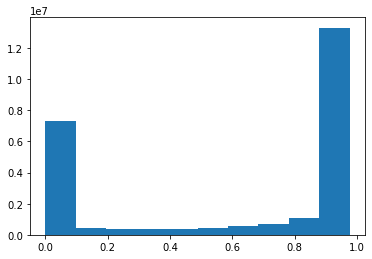

In [97]:
plt.hist(grad_F_rescaled.flatten())

### Do this for all 6 sides of the map

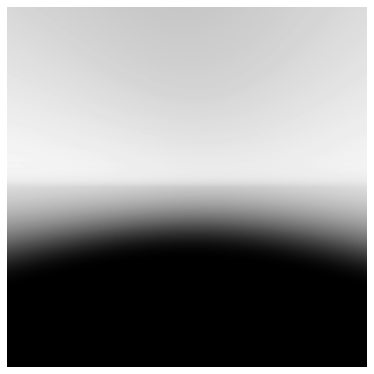

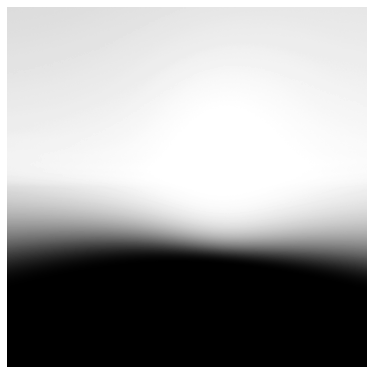

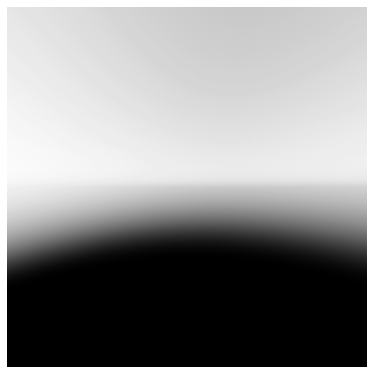

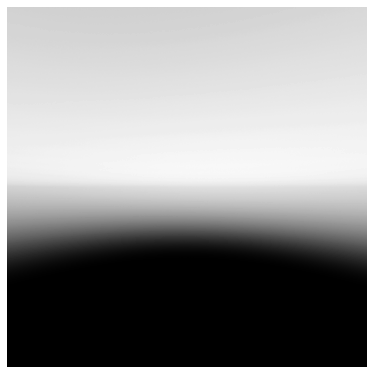

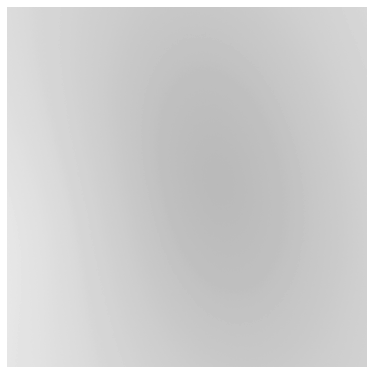

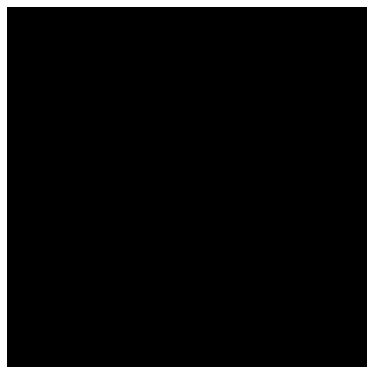

In [98]:
pt_per_cm = 150
dpiVal = 1000

maxBitSave = 2000

savename = '19h'
path = './skyGradients/'+savename+'/'

for side, name in enumerate(['Back','Right','Front','Left','Up','Down']):

    grad = np.asarray(Image.open(path + 'Skybox_mean_{}_{}.png'.format(name,savename)))

    #rescale image
    grad_rescaled = grad[:,:,0]/maxBit
    
    grad_reshaped = grad_rescaled.copy()
    grad_reshaped = InvFun(grad_rescaled, *popt) 
    grad_reshaped[np.where(grad_reshaped == -np.inf)] = 0
    grad_reshaped[np.where(grad_reshaped > 1)] = 1
        
    grad_reshaped = grad_reshaped*maxBitSave
    fig = plt.figure(frameon=False)
    fig.set_size_inches(5,5)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(grad_reshaped, vmin=0,vmax=maxBitSave, cmap='gray')
    fig.savefig(path+"Skybox_reshaped_{}_{}_{}.png".format(name,savename,postfix),dpi = dpiVal)

#### ...and the calibration images to check if it worked

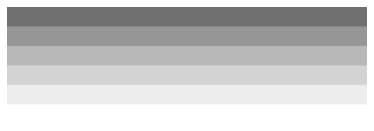

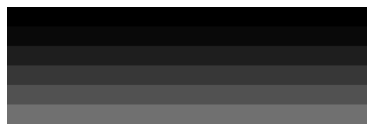

In [99]:
for c, cal in enumerate(['low','high']):
    img = np.asarray(Image.open('./calibration/BrightnessSteps_{}.png'.format(cal)))

    #rescale image
    img_rescaled = img[:,:,0]/maxBit

    img_reshaped = InvFun(img_rescaled, *popt) 
    img_reshaped[np.where(img_reshaped == -np.inf)] = 0
    img_reshaped[np.where(img_reshaped > 1)] = 1

    img_reshaped = img_reshaped*maxBitSave
    fig = plt.figure(frameon=False)
    fig.set_size_inches(5,5)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(img_reshaped, vmin=0,vmax=maxBitSave, cmap='gray')
    fig.savefig('./calibration/BrightnessSteps_{}_reshaped_{}.png'.format(cal,postfix),dpi = dpiVal)